In [12]:
%reload_ext autoreload
%autoreload 2

In [13]:
from fastai.vision import (ImageList, PointsItemList, get_transforms, ResizeMethod, open_image, Tensor, 
                           tensor, Image, imagenet_stats, Flatten, cnn_learner, models, Path)
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback
from fastprogress import progress_bar
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.nn.functional import mse_loss

In [14]:
images_path = '../data/resized_images'
labels_path = '../data/resized_labels.csv'
target_size = 320

In [15]:
y = pd.read_csv(labels_path, index_col='filename')

In [16]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    coord_list = []
    coords = list(y.loc[filename])
    for i in range(len(coords)//2):
        coord_list.append([coords[i*2+1],coords[i*2]])
    return tensor(coord_list)

In [17]:
transforms = get_transforms(
    do_flip=False,
    max_rotate=45, 
    max_zoom=1.5, 
    max_lighting=0.5, 
    max_warp=0.4, 
    p_affine=1., 
    p_lighting=1.
) 

In [18]:
data = (
    PointsItemList
        .from_folder(images_path)
        .split_by_rand_pct(0.15)
        .label_from_func(get_y_func)
        .transform(
            transforms,
            size=320,
            tfm_y=True, 
            remove_out=False, 
            padding_mode='reflection', 
            resize_method=ResizeMethod.PAD
        )
        .databunch()
        .normalize(imagenet_stats)
)

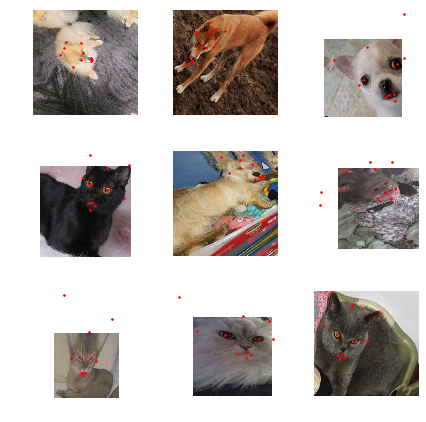

In [21]:
data.show_batch(3, figsize=(6,6))

In [22]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [23]:
head_reg = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(51200, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 22),
    Reshape(-1,11,2),
    nn.Tanh()
)

In [24]:
class MSELossFlat(nn.MSELoss):
    def forward(self, input:Tensor, target:Tensor):
        return super().forward(input.view(-1), target.view(-1)) 

mse_loss_flat = MSELossFlat()

learn = cnn_learner(
    data, 
    models.resnet34, 
    loss_func=mse_loss_flat,
    custom_head=head_reg
).to_fp16()

In [25]:
learn.path = Path('..')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


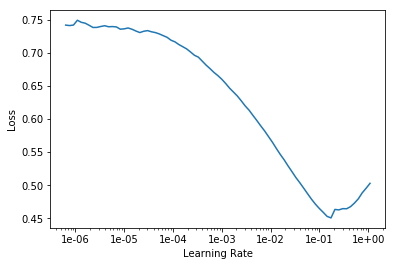

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.freeze_to(-1)
learn.fit_one_cycle(
    10, 
    slice(1e-2), 
    callbacks=[
        SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='resnet34_frozen_to_-1'),
        EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=10)
    ]
)

epoch,train_loss,valid_loss,time
0,0.302934,0.063946,01:11
1,0.133789,0.022767,01:11
2,0.083279,0.019594,01:11
3,0.070094,0.019853,01:11
4,0.077333,0.012333,01:11
5,0.058278,0.011340,01:10
6,0.053105,0.010842,01:11
7,0.052074,0.010366,01:10
8,0.051387,0.009269,01:10
9,0.048352,0.008909,01:11


Better model found at epoch 0 with valid_loss value: 0.0639456957578659.
Better model found at epoch 1 with valid_loss value: 0.022767260670661926.
Better model found at epoch 2 with valid_loss value: 0.01959412731230259.
Better model found at epoch 4 with valid_loss value: 0.012333220802247524.
Better model found at epoch 5 with valid_loss value: 0.011339947581291199.
Better model found at epoch 6 with valid_loss value: 0.01084163784980774.
Better model found at epoch 7 with valid_loss value: 0.010366460308432579.
Better model found at epoch 8 with valid_loss value: 0.009268807247281075.
Better model found at epoch 9 with valid_loss value: 0.008908693678677082.


In [20]:
learn.load('resnet34_frozen_to_-1')

In [21]:
learn.freeze_to(-2)
learn.fit_one_cycle(
    10, 
    slice(1e-3), 
    callbacks=[
        SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='resnet34_frozen_to_-2'),
        EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=10)
    ]
)

epoch,train_loss,valid_loss,time
0,0.043828,0.010062,01:19
1,0.049433,0.030984,01:20
2,0.061376,0.012416,01:20
3,0.049524,0.010783,01:21
4,0.050847,0.011380,01:21
5,0.055468,0.009588,01:21
6,0.043863,0.010675,01:21
7,0.042221,0.006810,01:20
8,0.039764,0.006471,01:21
9,0.036272,0.006352,01:20


Better model found at epoch 0 with valid_loss value: 0.010062254033982754.
Better model found at epoch 5 with valid_loss value: 0.009587562642991543.
Better model found at epoch 7 with valid_loss value: 0.006810098886489868.
Better model found at epoch 8 with valid_loss value: 0.006470976863056421.
Better model found at epoch 9 with valid_loss value: 0.006352448370307684.


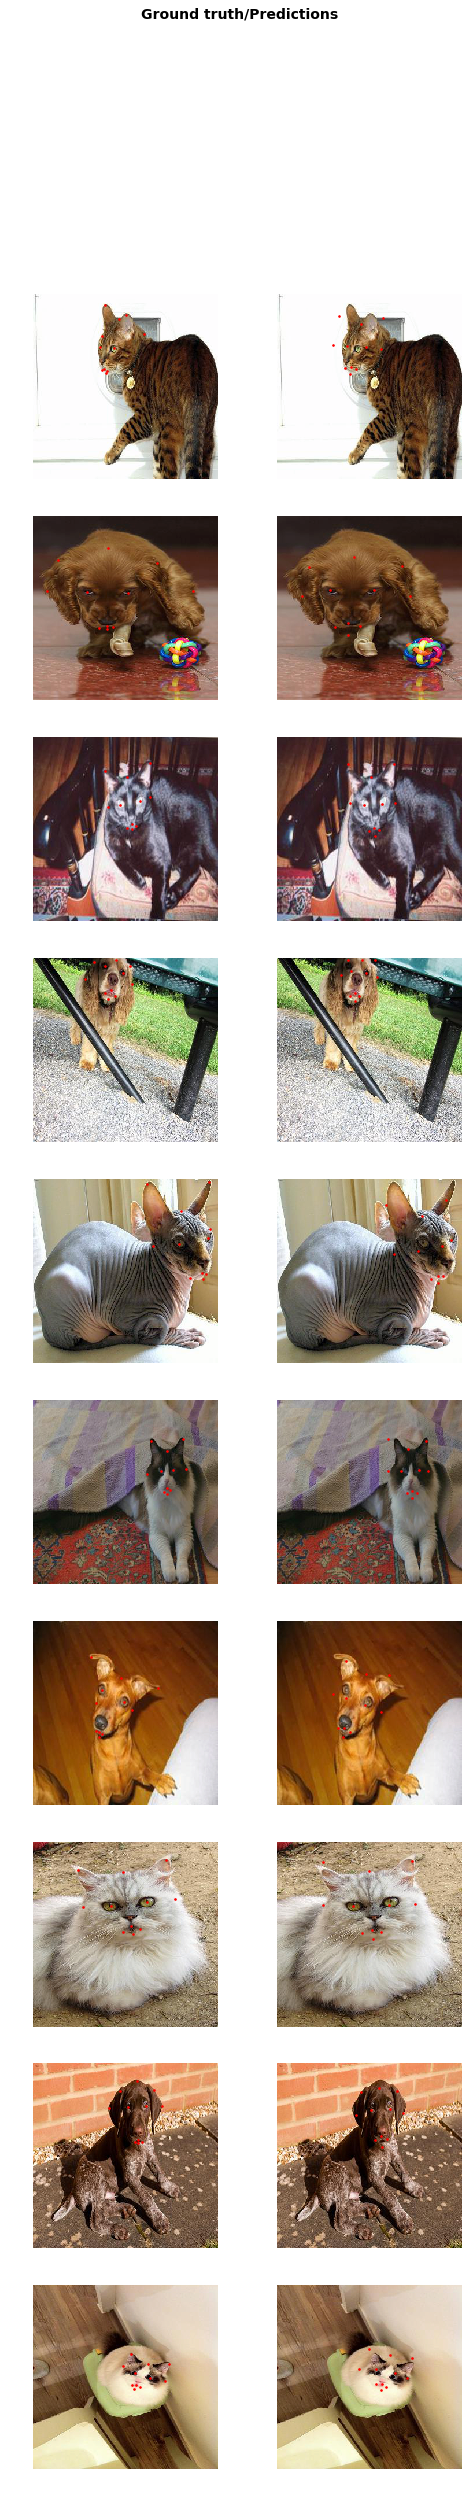

In [17]:
learn.show_results(rows=10)

In [36]:
data.export('../export.pkl')

In [1]:
import sagemaker
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import RealTimePredictor, json_deserializer
import torch
import os
import io
import deploy

In [2]:
model_dir = '../models/'
model_file = 'fastai_resnet34.pth'

JPEG_CONTENT_TYPE = 'image/jpeg'

url = "https://mtpcontent-dev.s3.amazonaws.com/ce99060e047d44279e0887270af5afe6.png"

In [3]:
model = deploy.model_fn('fastai_resnet34')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 55987360.06it/s]


In [4]:
img = deploy.input_fn(url)

In [5]:
response = deploy.predict_fn(img, model)

In [6]:
response[1]

tensor([[-0.0604, -0.6724],
        [-0.5513, -0.6641],
        [-0.5684, -0.0859],
        [-0.5928,  0.4431],
        [-0.1002,  0.5283],
        [ 0.4314, -0.0573],
        [-0.1129, -0.3157],
        [-0.1309,  0.1786],
        [ 0.3494, -0.1986],
        [ 0.2954, -0.0693],
        [ 0.3367,  0.0606]])

In [67]:
# TODO convert tensor output to json
# remember app needs to upsize to 640 * 640

output = deploy.output_fn(response[1])

TypeError: Object of type 'Tensor' is not JSON serializable